In [1]:
import numpy as np
import pyccl as ccl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pyccl.nl_pt as pt

import sys
sys.path.append('../bispectrum/')

import bihalofit
import importlib
importlib.reload(bihalofit)
import bispectrum
importlib.reload(bispectrum)

import fsb
importlib.reload(fsb)

<module 'fsb' from '/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/fsb.py'>

In [2]:
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['lines.linestyle'] = '-'  
matplotlib.rcParams['lines.color'] = 'black'

matplotlib.rcParams['patch.linewidth'] = 1.5
 
#fonts & text
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['font.size'] = 12.0
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['text.usetex'] = True
 
#axes & ticks
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1.  
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['axes.labelweight'] = 'normal'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.formatter.limits'] = [-4, 4]
 
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.major.pad'] = 6
matplotlib.rcParams['xtick.minor.pad'] = 6
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.width'] = 1.0
 
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.major.pad'] = 6
matplotlib.rcParams['ytick.minor.pad'] = 6
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.width'] = 1.0
 
#legends
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['legend.shadow'] = False
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.autolayout'] = True


In [3]:
colors = ['#e3a19c', '#85a1ca', '#596d82', '#725e9c', '#3d306b', '#AE7182']

Read FSB power spectra from Lea and David.

In [4]:
def read_fsb(fname):
    d = np.load(fname)
    Ls = d['Ls']
    ls = d['ls']
    
    print(d['fsbs'].shape)
    fsb = np.mean(d['fsbs'], axis=0)
    efsb = np.std(d['fsbs'], axis=0)
    cl = np.mean(d['cls'], axis=0)
    ecl = np.std(d['cls'], axis=0)
    return {'Ls': Ls, 'ls': ls, 'fsb': fsb, 'efsb': efsb, 'cl': cl, 'ecl': ecl}

dln = read_fsb("../../notebooks/fsb_largesky_nmt_submean.npz")

(630, 8, 47)


In [5]:
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.81, n_s = 0.96)

Read $n(z)$ for CMASS, also from David.

In [6]:
nzdata = np.load('../../data/nz_andrina.npz')

/users/anicola/anaconda3/envs/bisp_env_py11/lib/python3.11/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


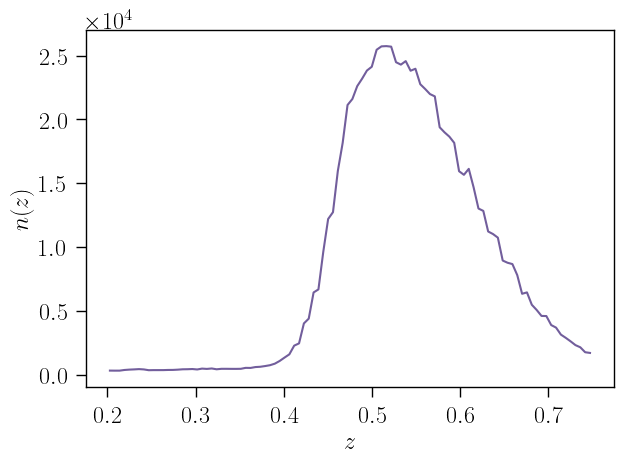

In [7]:
z = 0.5*(nzdata['z_lo']+nzdata['z_hi'])
nz = nzdata['nz']

plt.plot(z, nz, color=colors[3])
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')

tr1 = ccl.CMBLensingTracer(cosmo, z_source=1.) #CCL automatically normalizes dNdz

trl = ccl.WeakLensingTracer(cosmo, dndz=(z, nz)) #CCL automatically normalizes dNdz
trg = ccl.NumberCountsTracer(cosmo, dndz=(z, nz), has_rsd=False,bias=(z, np.ones_like(z))) #CCL automatically normalizes dNdz

In [8]:
# Matter
ptt_m = pt.PTMatterTracer()

# Biases for number counts 
b_1 = 2.0 # constant values for now
# b_2 = 1.0
# b_s = 1.0

# Number counts
# ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)
ptt_g = pt.PTNumberCountsTracer(b1=b_1)

## 3D power spectrum

In [9]:
ks = np.logspace(-2, 1, 300)

bkmmm = bispectrum.Bk(cosmo, ptt_m, ptt_m, ptt_m, np.array([1.]), ks, ks, ks, Bkm='halofit')

bkmmm_tree = bispectrum.Bk(cosmo, ptt_m, ptt_m, ptt_m, np.array([1.]), ks, ks, ks)

INFO:bispectrum:Computing Bmmm
INFO:bispectrum:Computing Bmmm


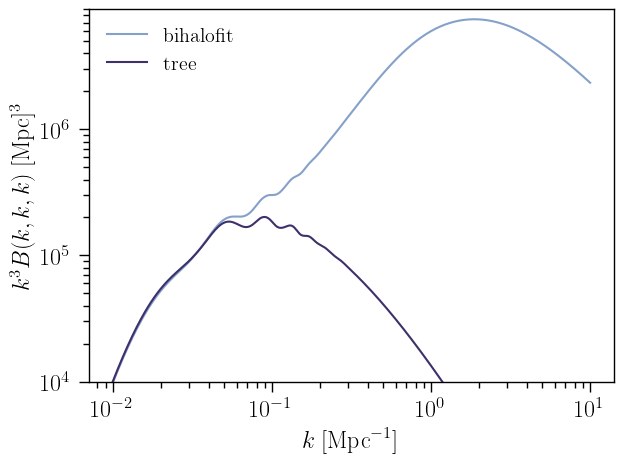

In [10]:
plt.loglog(ks, ks**3*bkmmm[0], color=colors[1], label='bihalofit')
plt.loglog(ks, ks**3*bkmmm_tree, color=colors[4], label='tree')
plt.ylim(1e4, 9e6)
plt.xlabel(r'$k\;[\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$k^3B(k, k, k)\;[\mathrm{Mpc}]^3$')
plt.legend()

## Angular shear bispectrum

As a test, let's do cosmic shear.

In [11]:
ells = np.logspace(0, 4, 100)

In [12]:
blmmm = bispectrum.Bl(cosmo, trl, trl, trl, ptt_m, ptt_m, ptt_m, ells, ells, ells, Bkm='halofit')

INFO:bispectrum:Computing Bmmm


In [13]:
blmmm_tree = bispectrum.Bl(cosmo, trl, trl, trl, ptt_m, ptt_m, ptt_m, ells, ells, ells)

INFO:bispectrum:Computing Bmmm


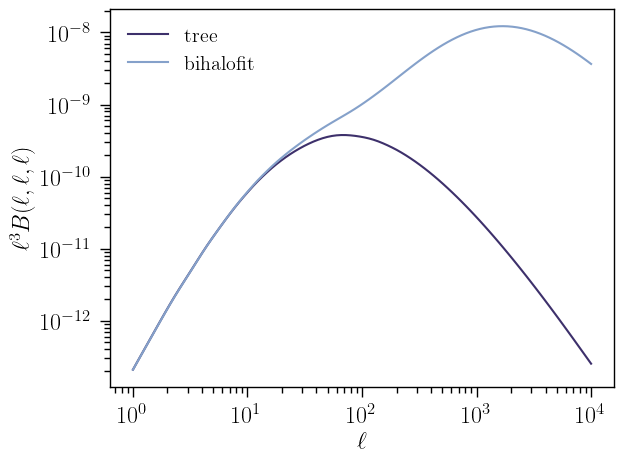

In [14]:
plt.loglog(ells, ells**3*blmmm_tree, label=r'$\mathrm{tree}$', color=colors[4])
plt.loglog(ells, ells**3*blmmm, label=r'$\mathrm{bihalofit}$', color=colors[1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^3B(\ell, \ell, \ell)$')
plt.legend()

## FSB

First compare $C_{\ell}$'s:

In [15]:
ells = np.arange(800)

cls = ccl.angular_cl(cosmo=cosmo, tracer1=trg, tracer2=trg, ell=ells)

Text(0, 0.5, '$C_\\ell$')

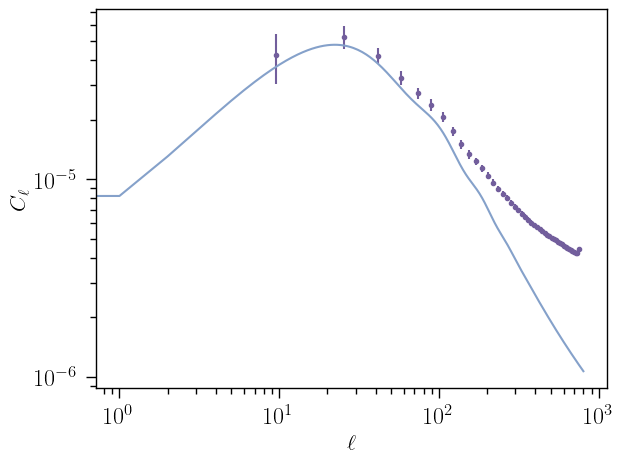

In [16]:
plt.figure()
plt.errorbar(dln['ls'], dln['cl'], yerr=dln['ecl'], marker='.', linestyle='None', color=colors[3])
plt.plot(ells, 2**2*cls, color=colors[1])
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)

In [17]:
ls_binarr = np.linspace(1, 96*7+1, 8, dtype='int')
ll_bins = np.linspace(1, 753, 48, dtype='int')

nbin_ls = ls_binarr.shape[0]-1
nbin_ll = ll_bins.shape[0]-1

Bk_fsb = np.zeros((nbin_ls, nbin_ll))
Bk_fsb_hlft = np.zeros((nbin_ls, nbin_ll))

myfsb = fsb.FSB()

for i in range(len(ls_binarr)-1):
    ls_bins = ls_binarr[i:i+2]
    print('ls bins = ', ls_bins)
    Bk_fsb_temp, Bl = myfsb.Bk_fsb(cosmo, trg, trg, trg, ptt_g, ptt_g, ptt_g, ls_bins, ll_bins, \
                                 Bkm='tree', nbar=303556)
    Bk_fsb[i, :] = Bk_fsb_temp
    Bk_fsb_hlft_temp, Bl_hlft = myfsb.Bk_fsb(cosmo, trg, trg, trg, ptt_g, ptt_g, ptt_g, \
                                                 ls_bins, ll_bins, Bkm='halofit', nbar=303556)
    Bk_fsb_hlft[i, :] = Bk_fsb_hlft_temp

ls bins =  [ 1 97]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.


/users/anicola/anaconda3/envs/bisp_env_py11/lib/python3.11/site-packages/pyccl/pk2d.py:287: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bispectrum.py:55: RuntimeWarning: divide by zero encountered in divide
  cos12 = (k3**2 - k1**2 - k2**2) / (2*k1*k2)
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bispectrum.py:55: RuntimeWarning: invalid value encountered in divide
  cos12 = (k3**2 - k1**2 - k2**2) / (2*k1*k2)
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bispectrum.py:57: RuntimeWarning: divide by zero encountered in divide
  F2 = 5./7 + 0.5*cos12*(k1/k2+k2/k1) + 2./7*cos12**2
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bispectrum.py:57: RuntimeWarning: invalid value encountered in add
  F2 = 5./7 + 0.5*cos12*(k1/k2+k2/k1) + 2./7*cos12**2


INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.


/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bihalofit.py:195: RuntimeWarning: divide by zero encountered in divide
  (1./(an*q3**alphan + self.bn*q3**betan)) *  (1./(1. + (self.cn*q3)**-1))
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bihalofit.py:195: RuntimeWarning: divide by zero encountered in reciprocal
  (1./(an*q3**alphan + self.bn*q3**betan)) *  (1./(1. + (self.cn*q3)**-1))
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bihalofit.py:193: RuntimeWarning: invalid value encountered in multiply
  B1h = (1./(an*q1**alphan + self.bn*q1**betan)) * (1./(1. + (self.cn*q1)**-1)) * \
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bihalofit.py:222: RuntimeWarning: divide by zero encountered in divide
  PE = (1.+fn*q**2)/(1.+gn*q+hn*q**2)*Pklin + 1./(mn*q**mun+nn*q**nun)*1./(1.+(pn*q)**-3)
/users/anicola/Work/projects/bispectrum/code/notebooks/../bispectrum/bihalofit.py:222: RuntimeWarning: divide b

ls bins =  [ 97 193]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [193 289]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [289 385]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [385 481]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [481 577]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the 

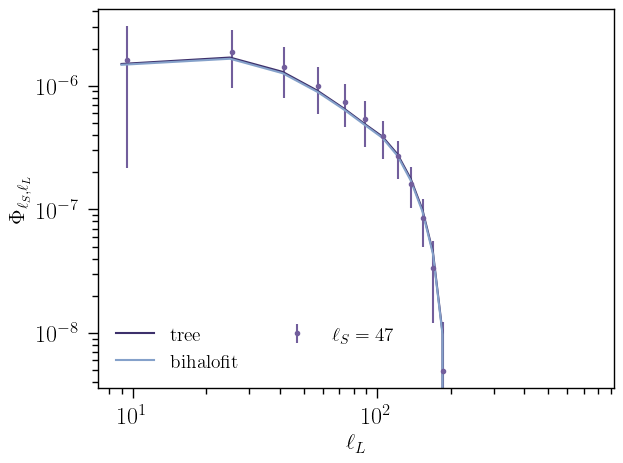

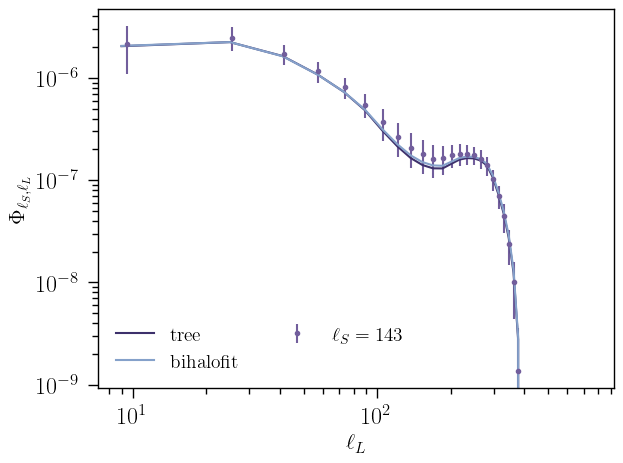

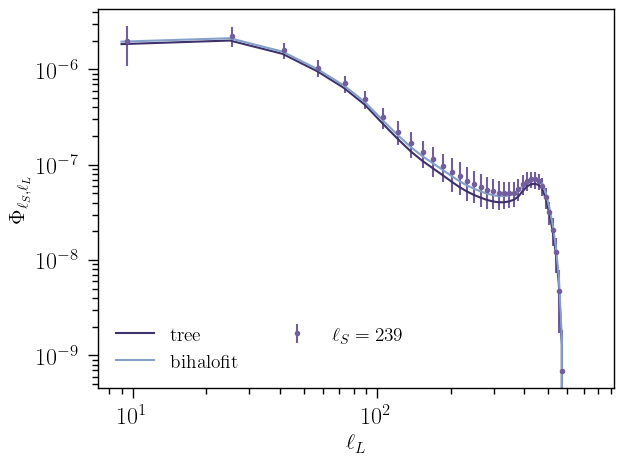

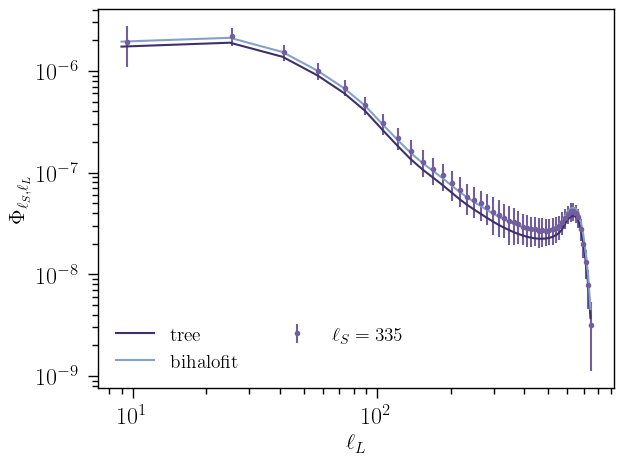

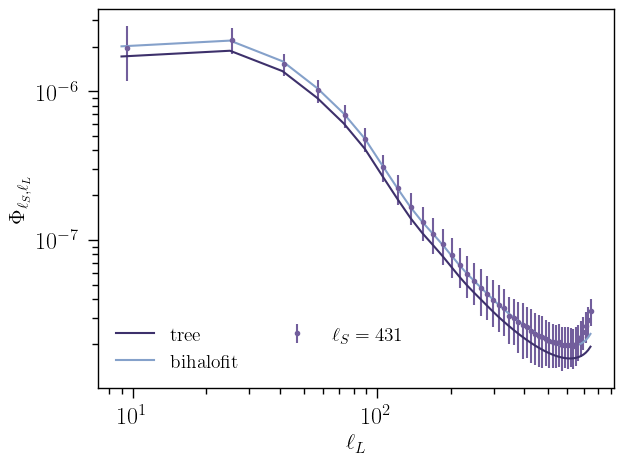

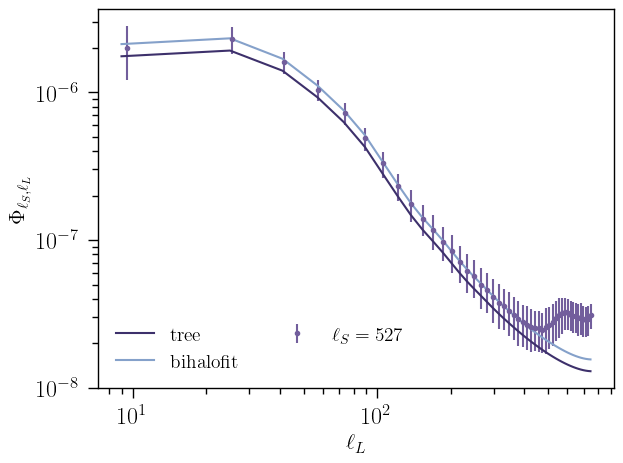

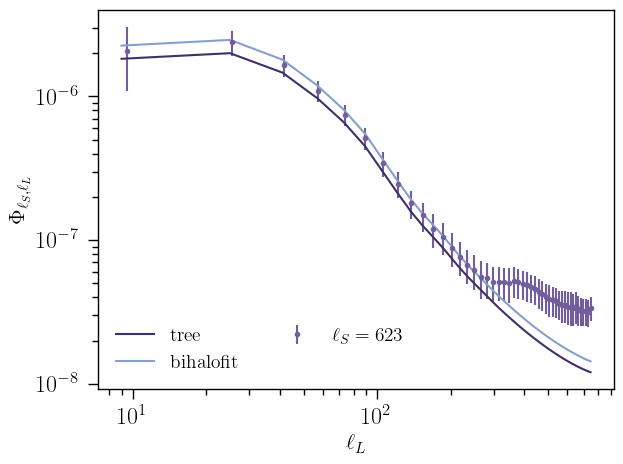

In [19]:
ll_means = 0.5*(ll_bins[:-1]+ll_bins[1:])

for i, L in enumerate(dln['Ls'][:-1]):
    plt.figure()
    plt.errorbar(dln['ls'], dln['fsb'][i], yerr=dln['efsb'][i], fmt='.', label=f'$\\ell_S=%d$' % (int(L)), color=colors[3])
    plt.loglog(ll_means, Bk_fsb[i, :], label=r'$\mathrm{tree}$', color=colors[4])
    plt.loglog(ll_means, Bk_fsb_hlft[i, :], label=r'$\mathrm{bihalofit}$', color=colors[1])
    plt.xlabel('$\\ell_L$', fontsize=16)
    plt.ylabel('$\\Phi_{\\ell_S,\\ell_L}$', fontsize=16)
    plt.legend(loc='lower left', fontsize=14, frameon=False, ncol=2)

In [9]:
ls_binarr = np.linspace(1, 96*7+1, 8, dtype='int')
ll_bins = np.linspace(1, 753, 48, dtype='int')

nbin_ls = ls_binarr.shape[0]-1
nbin_ll = ll_bins.shape[0]-1

Bk_fsb_intp = np.zeros((nbin_ls, nbin_ll))
Bk_fsb_hlft_intp = np.zeros((nbin_ls, nbin_ll))

myfsb = fsb.FSB()

for i in range(len(ls_binarr)-1):
    ls_bins = ls_binarr[i:i+2]
    print('ls bins = ', ls_bins)
    Bk_fsb_temp, Bl = myfsb.Bk_fsb_interp(cosmo, trg, trg, trg, ptt_g, ptt_g, ptt_g, ls_bins, \
                                          ll_bins, Bkm='tree', nbar=303556)
    Bk_fsb_intp[i, :] = Bk_fsb_temp
    
myfsb = fsb.FSB()

for i in range(len(ls_binarr)-1):
    ls_bins = ls_binarr[i:i+2]
    print('ls bins = ', ls_bins)
    Bk_fsb_hlft_temp, Bl_hlft = myfsb.Bk_fsb_interp(cosmo, trg, trg, trg, ptt_g, ptt_g, ptt_g, \
                                                 ls_bins, ll_bins, Bkm='halofit', nbar=303556)
    Bk_fsb_hlft_intp[i, :] = Bk_fsb_hlft_temp

ls bins =  [ 1 97]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [ 97 193]
ls bins =  [193 289]
ls bins =  [289 385]
ls bins =  [385 481]
ls bins =  [481 577]
ls bins =  [577 673]
ls bins =  [ 1 97]
INFO:bispectrum:Computing Bggg
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [ 97 193]
ls bins =  [193 289]
ls bins =  [289 385]
ls bins =  [385 481]
ls bins =  [481 577]
ls bins =  [577 673]


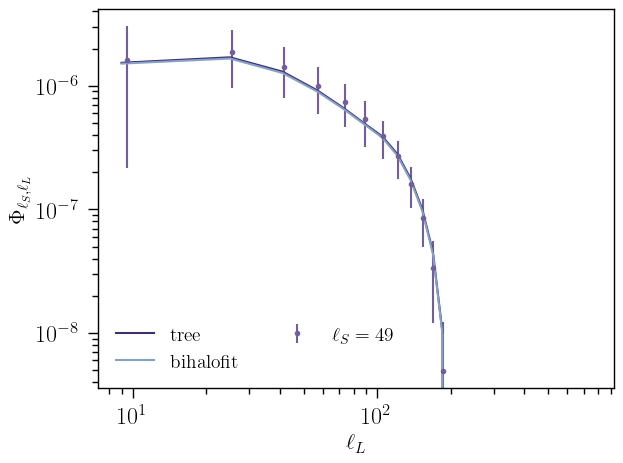

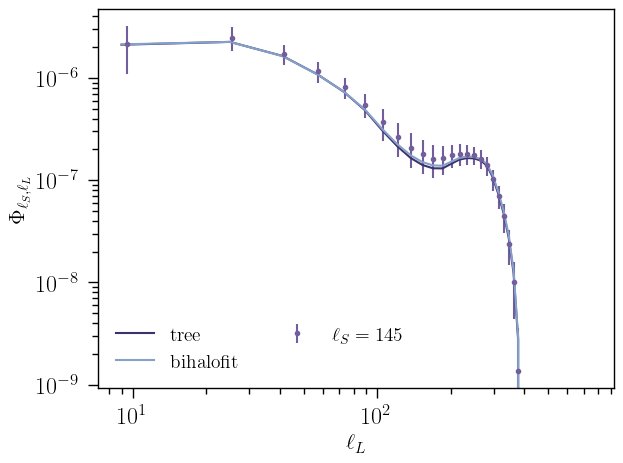

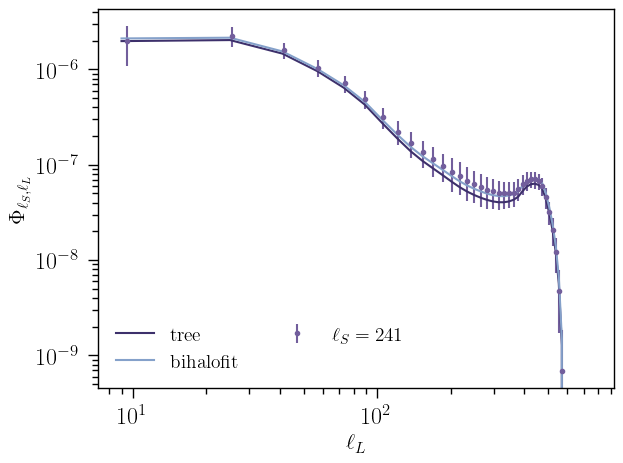

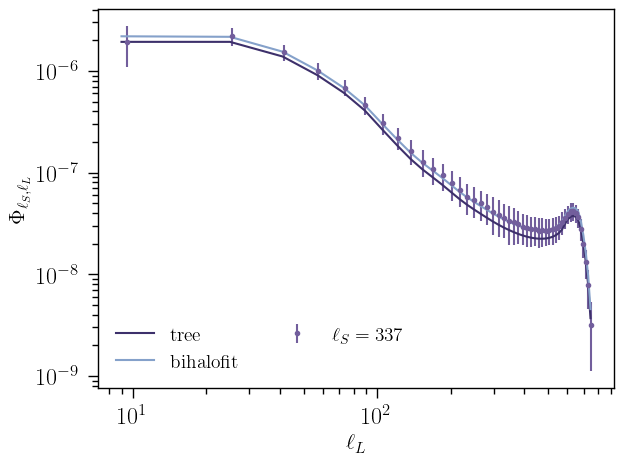

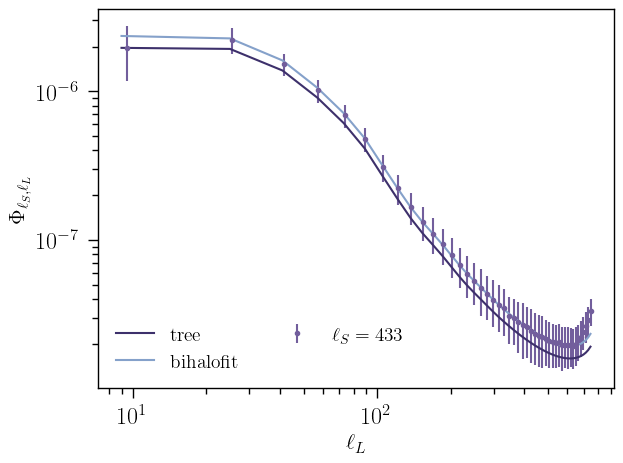

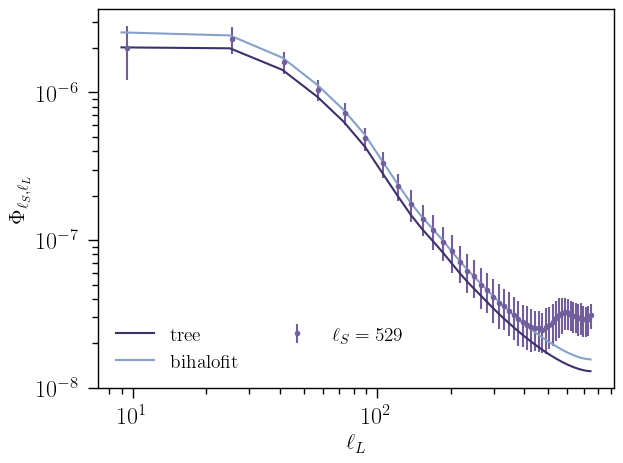

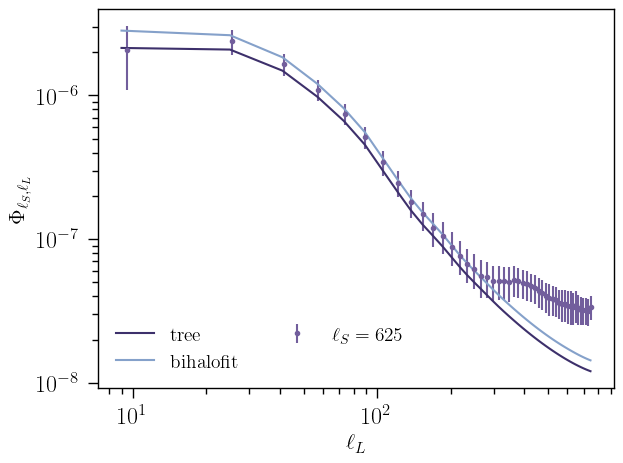

In [11]:
ll_means = 0.5*(ll_bins[:-1]+ll_bins[1:])

ls_bin_means = 0.5*(ls_binarr[:-1]+ls_binarr[1:])

for i in range(ls_bin_means.shape[0]):
    plt.figure()
    plt.errorbar(dln['ls'], dln['fsb'][i], yerr=dln['efsb'][i], fmt='.', label=f'$\\ell_S=%d$' % (int(ls_bin_means[i])), color=colors[3])
    plt.loglog(ll_means, Bk_fsb_intp[i, :], label=r'$\mathrm{tree}$', color=colors[4])
    plt.loglog(ll_means, Bk_fsb_hlft_intp[i, :], label=r'$\mathrm{bihalofit}$', color=colors[1])
    plt.xlabel('$\\ell_L$', fontsize=16)
    plt.ylabel('$\\Phi_{\\ell_S,\\ell_L}$', fontsize=16)
    plt.legend(loc='lower left', fontsize=14, frameon=False, ncol=2)